In [36]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import datetime
import pandas as pd
from xhistogram.xarray import histogram
from scipy import stats, optimize, interpolate

In [140]:
#acyc eddy dataset
datadir = '/data/data_pub/eddy_traj/META3.1exp_DT_allsat_Anticyclonic_long_19930101_20200307.nc'
ds = xr.open_dataset(datadir, decode_times=False)


In [127]:
#etopo
ds_dep = xr.open_dataset('ETOPO1_Bed_g_gmt4.grd')
ds_dep = ds_dep.z.interp(x=np.linspace(-180,179.9,3600), y=np.linspace(-80,79.9,1600))

# convert -180-180 to 0-360
lon_name = 'x'  # whatever name is in the data

# Adjust lon values
ds_dep['_longitude_adjusted'] = xr.where(
    ds_dep[lon_name] < 0,
    ds_dep[lon_name] + 360,
    ds_dep[lon_name])

# reassign the new coords to as the main lon coords
# and sort DataArray using new coordinate values

ds_dep = (ds_dep.swap_dims({lon_name: '_longitude_adjusted'})
      .sel(**{'_longitude_adjusted': sorted(ds_dep._longitude_adjusted)}).drop(lon_name))
ds_dep = ds_dep.rename({'_longitude_adjusted': lon_name})

In [105]:
#load eddy data
amp = ds.amplitude.values
lon = ds.longitude.values
lat = ds.latitude.values
track = ds.track.values

In [106]:
#compute dh
damp = np.diff(amp)
dtrk = np.diff(track)
damp[dtrk!=0] = 0
lon_new = lon[:-1]
lat_new = lat[:-1]

binx = np.arange(0, 360.1, 1)
biny = np.arange(-80, 80.1, 1)

sta = stats.binned_statistic_2d(lon_new, lat_new, damp, statistic='mean', bins=[binx, biny], range=None)

## global map for dh of eddies (top) and global topo (bottom)

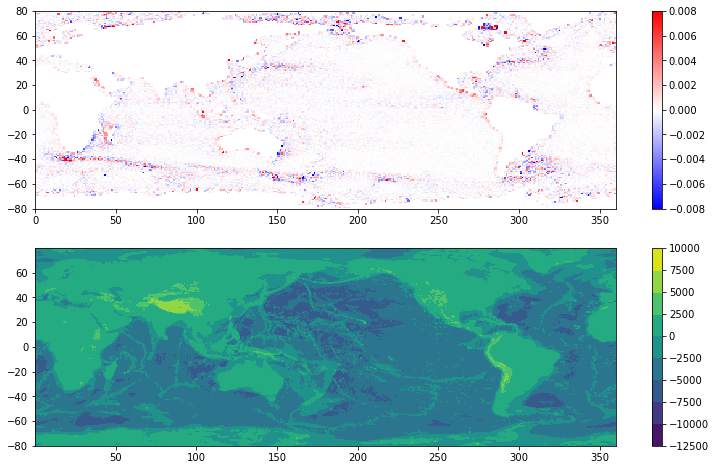

In [137]:
fig = plt.figure(figsize=(13, 8))
plt.subplot(211)
plt.pcolormesh(binx, biny, sta[0].T, cmap='bwr', vmin=-0.008, vmax=0.008)
plt.colorbar()

#dep = ds_dep.values
#dep[dep>-1000] = np.nan
#dep[dep<-4000] = np.nan
plt.subplot(212)
plt.contourf(ds_dep.x, ds_dep.y, ds_dep)
plt.colorbar()

## zoom in around the specific region

(10.0, 30.0)

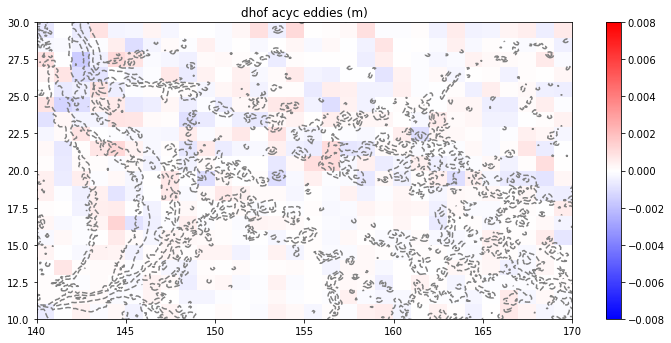

In [142]:
fig = plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.pcolormesh(binx, biny, sta[0].T, cmap='bwr', vmin=-0.008, vmax=0.008)
plt.title('dhof acyc eddies (m)')
plt.colorbar()
plt.contour(ds_dep.x, ds_dep.y, ds_dep, colors='grey')

plt.xlim(140, 170)
plt.ylim(10, 30)